# Data Source

## Google trend on virus
- https://trends.google.com/trends/explore?date=today%203-m&geo=US&q=%2Fm%2F01cpyy
- coronavirus was only confirmed in Feb, and it has a different time series as the word virus

# Daily count on Wikipedia
- Mainland China: https://en.wikipedia.org/wiki/2019%E2%80%9320_coronavirus_outbreak_in_mainland_China
- Outside China: https://en.wikipedia.org/wiki/Template:2019%E2%80%9320_coronavirus_outbreak_data/International_medical_cases
- Outside China: https://en.wikipedia.org/wiki/Template:2019%E2%80%9320_coronavirus_pandemic_data/WHO_situation_reports
- US: https://en.wikipedia.org/wiki/Template:2019%E2%80%9320_coronavirus_outbreak_data/International_medical_cases


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.optimize import curve_fit
from scipy import stats
from datetime import date, timedelta

/Users/btong/Envs/PlayGround/lib/python3.6/site-packages/pandas/compat/__init__.py:84: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/Users/btong/Envs/PlayGround/lib/python3.6/site-packages/pandas/compat/__init__.py:84: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
df_world = pd.read_csv("Data/World_noChina_20200307.csv")
df_world = df_world.fillna(0)

In [3]:
df_china = pd.read_csv("Data/China_20200307.csv")
df_china = df_china.fillna(0)

In [4]:
df_us = pd.read_csv("Data/US_20200307.csv")
df_us = df_us.fillna(0)

In [5]:
# df_us['Cases'] = df_us['Cases'].cumsum()
# df_us.to_csv("Data/us_20200307.csv", index=False)

In [6]:
# df_china["Cases"] = df_china["Cases"].apply(lambda x: int(x.replace(",", "")))
# df_china.to_csv("Data/China_20200307.csv", index=False)

In [7]:
tmr_date = date.today() # +  timedelta(days=1)

1.959963984540054
[1.26284610e+00 8.17669293e+04 1.26639937e+00 2.53558466e+01]
81718 81728 81736


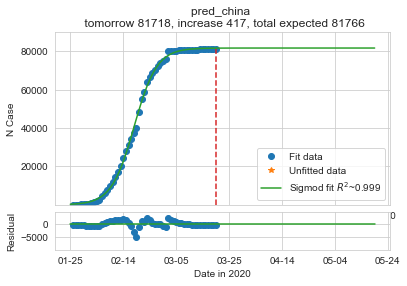

In [8]:
# Define confidence interval.
ci = 0.95
# Convert to percentile point of the normal distribution.
# See: https://en.wikipedia.org/wiki/Standard_score
pp = (1. + ci) / 2.
# Convert to number of standard deviations.
nstd = stats.norm.ppf(pp)
print(nstd)

sns.set_style("whitegrid")

def sigmoid(x, a, n, b, c):
    y = n * 1 / (1  +  b * n * a ** (-c - x))
    return y

def r_squared(x_data, y_data, func, popt):
    """Compute R squared given the input data and func."""
    residuals = y_data - func(x_data, *popt)
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y_data-np.mean(y_data))**2)
    r_squared = 1 - (ss_res / ss_tot)
    return r_squared

def prediction(dates, total, my_func, name="sigmoid"):
    total = list(total)
    # initial guess for curve fit coefficients
    starting_index = 0
    x_prev_data = np.arange(-starting_index + 1, 1)
    y_prev_data = np.array(total[:starting_index])
    xdata = np.arange(1, len(total[starting_index:])+1)
    ydata = np.array(total[starting_index:])
    
    guess = [1.3, 100000, 2.2, 10]
    popt, pcov = curve_fit(my_func, xdata, ydata, p0=guess, sigma=np.sqrt(xdata), bounds=([0, 2E3, 0, 0], [30, 8E6, 50, 50]))
    print(popt)
    R2 = r_squared(xdata, ydata, my_func, popt)

    perr = np.sqrt(np.diag(pcov))
    popt_up = popt + nstd * perr
    popt_down = popt - nstd * perr
    
    forward_steps = 60
    x = np.linspace(-starting_index, len(total) - starting_index + forward_steps, 100)
    y = my_func(x, *popt)

    tmr = len(xdata) + 1
    pred = int(my_func(tmr, *popt))
    pred_up = int(my_func(tmr, *popt_up))
    # pred_down = int(my_func(tmr, *popt_down))
    # print(pred_up, pred_down)
    print(pred, int(my_func(tmr + 1, *popt)), int(my_func(tmr + 2, *popt)))
    
    fig = plt.figure(constrained_layout=False)
    gs = fig.add_gridspec(nrows=5, ncols=4)
    ax1 = fig.add_subplot(gs[0:-1, :])
    ax2 = fig.add_subplot(gs[-1, :])
   
    total_expected = int(popt[1])
    ax1.plot(xdata, ydata, 'o', label='Fit data')
    ax1.plot(x_prev_data, y_prev_data, '*', label='Unfitted data')
    ax1.plot(x, y, label=r'Sigmod fit $R^2$~{}'.format(round(R2, 3)))
    ax1.plot([len(total) - starting_index, len(total) - starting_index], [0, ydata[-1]], '--')
    ax1.set_title("{} \n tomorrow {}, increase {}, total expected {}".format(name, pred, pred - total[-1], total_expected))
    ax1.set_ylim(1, total_expected * 1.1)
    ax1.legend(loc='best')
    # ax1.set_xticks([])
    # ax1.set_xlabel('Date')
    ax1.set_ylabel('N Case')
    
    residuals = ydata - my_func(xdata, *popt)
    prev_residuals = y_prev_data - my_func(x_prev_data, *popt)
    ax2.plot(xdata, residuals, 'o', label='residuals')
    ax2.plot(x_prev_data, prev_residuals, '*', label='prev residuals')
    ax2.plot(x, np.zeros(len(x)))
    ax2.set_ylim(min(residuals) * 2, max(residuals) * 2)
    ax2.set_xlabel('Date in 2020')
    ax2.set_ylabel('Residual')
    x_ticks = ax2.get_xticks()
    # print(x_ticks)
    current_day = len(total) - starting_index
    # correct time difference
    current_date = date.today() + timedelta(days=1)
    date_ticks = []
    for x_tick in x_ticks:
        date_ticks.append(current_date + timedelta(days=x_tick - current_day))
    date_ticks = [i.strftime('%m-%d') for i in date_ticks]
    ax2.set_xticklabels(date_ticks)
    # print(date_ticks)
    plt.savefig('Plots/{}_{}.png'.format(tmr_date, name), dpi=300)
    plt.show()
    
prediction(df_china["Date"], df_china["Cases"], sigmoid, "pred_china")

/Users/btong/Envs/PlayGround/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


[1.18934136e+00 7.99999914e+06 3.94632127e+00 1.86497233e+01]
174486 206670 244604


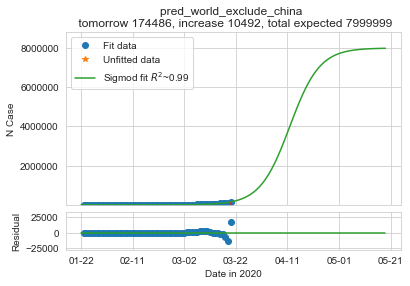

In [9]:
df_world_selected = df_world[df_world['Date'] > '2020-01-20']
df_world_selected["Cases"] = df_world_selected["Cases"] - df_world_selected["Cases"].values[0]
prediction(df_world_selected["Date"], df_world_selected["Cases"], sigmoid, "pred_world_exclude_china")

/Users/btong/Envs/PlayGround/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


[1.34445306e+00 7.99999973e+06 9.19174682e-01 1.12037196e+01]
14977 20123 27031


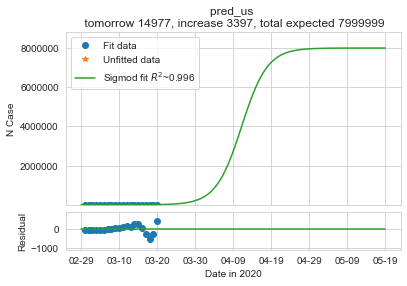

In [10]:
df_us_selected = df_us[df_us['Date'] > '2020-02-28']
df_us_selected["Cases"] = df_us_selected["Cases"] - df_us_selected["Cases"].values[0]
prediction(df_us_selected["Date"], df_us_selected["Cases"], sigmoid, "pred_us")

In [11]:
# days_to_predict = 100
# days = []
# # first_day = pd.to_datetime('20.1.13'.replace(',', '/'), yearfirst=True)
# current_date = pd.to_datetime(df_world["Date"][0])
# for i in range(days_to_predict):
#     days.append(current_date)
#     current_date  += timedelta(days=1)
# pred_world = sigmoid(np.arange(0, days_to_predict), *[1.22191097e+00, 1.74020941e+05, 5.05164051e+00, 5.32881968e+00])

# df = pd.DataFrame({"Date": days, "Cases": pred_world})
# df.to_csv("Data/World_prediction.csv", index=False)

In [12]:
# df['Date'] = df['Date'].apply(lambda x:  pd.to_datetime(x.replace(',', '/'), yearfirst=True))
